In [1]:
# Step 1: Install and import libraries
!pip install dlib
!pip install opencv-python-headless scikit-learn numpy torch torchvision matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

NameError: name 'Dataset' is not defined

Total Training Data: 40980
Training Split: 32784
Validation Split: 8196
Test Set: 10246


Extracting features: 100%|██████████| 321/321 [06:49<00:00,  1.27s/it]


Train features shape: (15258, 136), Train labels shape: (15258,)
Validation features shape: (3756, 136), Validation labels shape: (3756,)
Test features shape: (6989, 136), Test labels shape: (6989,)
Validation Accuracy: 62.57%
Test Accuracy: 62.34%

Classification Report:
               precision    recall  f1-score   support

    Satisfied       0.76      0.76      0.76      2988
Non-Satisfied       0.52      0.78      0.63      2635
      Neutral       0.62      0.02      0.04      1366

     accuracy                           0.62      6989
    macro avg       0.63      0.52      0.48      6989
 weighted avg       0.64      0.62      0.57      6989



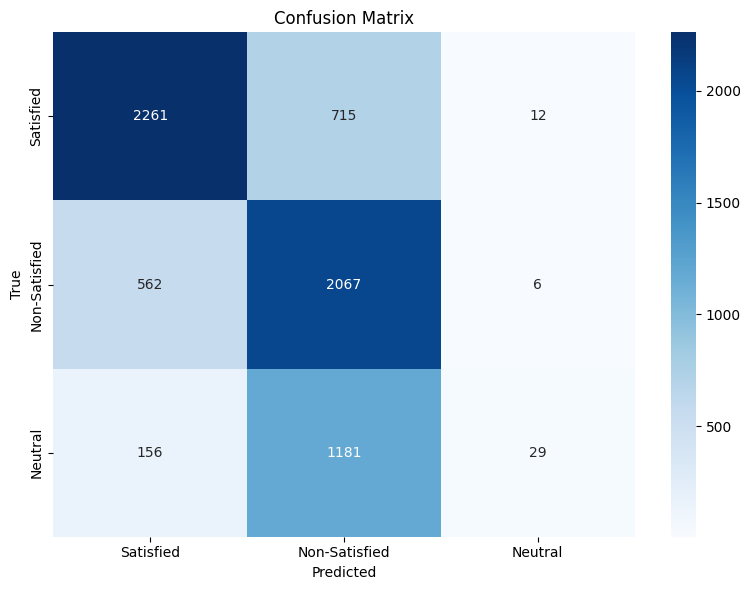

Saved SVM model and scaler to /kaggle/working/


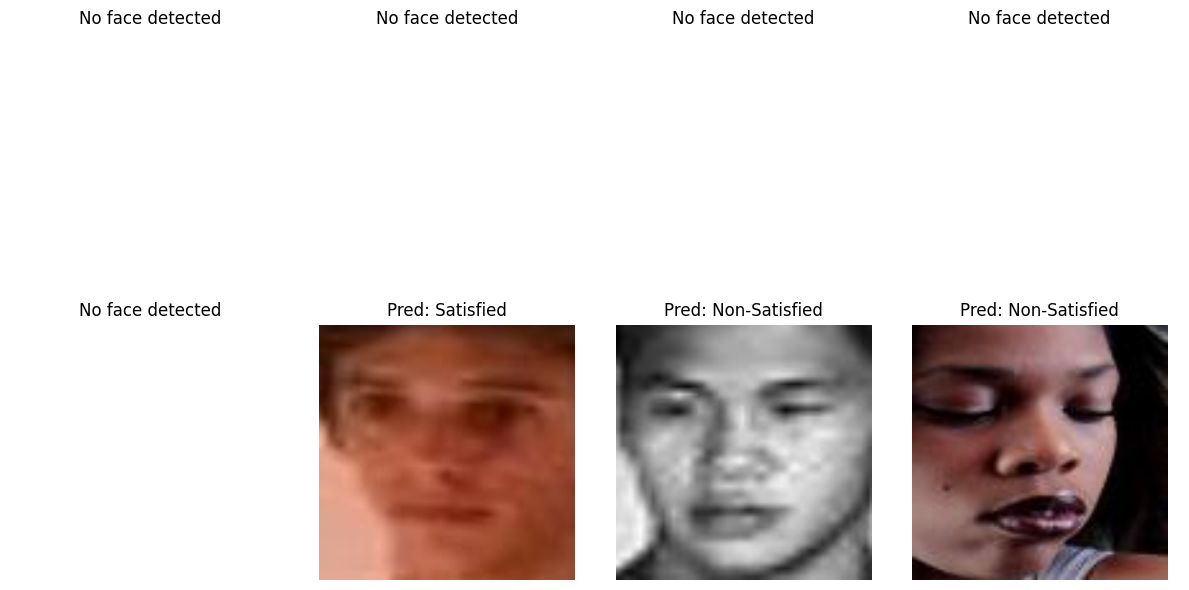

In [3]:
import os
import cv2
import dlib
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split, Dataset  # Added Dataset import
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib

# Step 2: Define datasets
emotion_labels = {0: "Happy", 1: "Surprise", 2: "Sad", 3: "Anger", 4: "Disgust", 5: "Fear", 6: "Neutral"}

class RAFDBDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {1: 1, 2: 5, 3: 4, 4: 0, 5: 2, 6: 3, 7: 6}
        self.image_data = []
        for class_folder in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_folder)
            if os.path.isdir(class_path) and class_folder.isdigit():
                label = int(class_folder)
                if label in self.label_map:
                    for filename in os.listdir(class_path):
                        if filename.endswith(".jpg") or filename.endswith(".png"):
                            self.image_data.append([filename, label])
        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_name, original_label = self.image_data[idx]
        mapped_label = self.label_map[original_label]
        img_path = os.path.join(self.img_dir, str(original_label), img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, mapped_label

class FER2013Dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'happy': 0, 'surprise': 1, 'sad': 2, 'angry': 3, 'disgust': 4, 'fear': 5, 'neutral': 6}
        self.image_data = []
        for emotion in os.listdir(img_dir):
            emotion_path = os.path.join(img_dir, emotion)
            if os.path.isdir(emotion_path) and emotion in self.label_map:
                for filename in os.listdir(emotion_path):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.image_data.append((os.path.join(emotion_path, filename), self.label_map[emotion]))
        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_path, label = self.image_data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
base_path_rafdb = "/kaggle/input/raf-db-dataset"
train_img_dir_rafdb = os.path.join(base_path_rafdb, "DATASET/train")
test_img_dir_rafdb = os.path.join(base_path_rafdb, "DATASET/test")

base_path_fer2013 = "/kaggle/input/fer2013"
train_img_dir_fer2013 = os.path.join(base_path_fer2013, "train")
test_img_dir_fer2013 = os.path.join(base_path_fer2013, "test")

for path in [train_img_dir_rafdb, test_img_dir_rafdb, train_img_dir_fer2013, test_img_dir_fer2013]:
    if not os.path.exists(path):
        print(f"Warning: Directory not found at {path}")

rafdb_train_dataset = RAFDBDataset(img_dir=train_img_dir_rafdb, transform=train_transforms)
fer2013_train_dataset = FER2013Dataset(img_dir=train_img_dir_fer2013, transform=train_transforms)
full_train_dataset = ConcatDataset([rafdb_train_dataset, fer2013_train_dataset])

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

rafdb_test_dataset = RAFDBDataset(img_dir=test_img_dir_rafdb, transform=test_transforms)
fer2013_test_dataset = FER2013Dataset(img_dir=test_img_dir_fer2013, transform=test_transforms)
combined_test_dataset = ConcatDataset([rafdb_test_dataset, fer2013_test_dataset])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

print(f"Total Training Data: {len(full_train_dataset)}")
print(f"Training Split: {len(train_dataset)}")
print(f"Validation Split: {len(val_dataset)}")
print(f"Test Set: {len(combined_test_dataset)}")

# Step 3: Define landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/kaggle/input/shape_predictor_68_face_landmarks/tensorflow2/default/1/shape_predictor_68_face_landmarks (1).dat")

def get_landmarks(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = image.permute(1, 2, 0).numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1) * 255
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = detector(img, 1)
    if len(faces) == 0:
        return None
    shape = predictor(img, faces[0])
    landmarks = []
    for i in range(68):
        landmarks.append(shape.part(i).x)
        landmarks.append(shape.part(i).y)
    return np.array(landmarks, dtype=np.float32)

# Step 4: Map emotions to satisfaction
def emotion_to_satisfaction(label):
    if label in [0, 1]:
        return 0  # Satisfied
    elif label in [2, 3, 4, 5]:
        return 1  # Non-Satisfied
    else:
        return 2  # Neutral

satisfaction_labels = {0: "Satisfied", 1: "Non-Satisfied", 2: "Neutral"}

# Step 5: Extract features
def extract_features(dataset, loader):
    features = []
    labels = []
    for images, emotion_labels in tqdm(loader, desc="Extracting features"):
        for img, emo_label in zip(images, emotion_labels):
            landmarks = get_landmarks(img)
            if landmarks is not None:
                features.append(landmarks)
                sat_label = emotion_to_satisfaction(emo_label.item())
                labels.append(sat_label)
    return np.array(features), np.array(labels)

train_features, train_labels = extract_features(train_dataset, train_loader)
val_features, val_labels = extract_features(val_dataset, val_loader)
test_features, test_labels = extract_features(combined_test_dataset, test_loader)

print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

# Step 6: Train SVM
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(train_features, train_labels)

val_predictions = svm.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Step 7: Evaluate model
test_predictions = svm.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=list(satisfaction_labels.values())))

cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(satisfaction_labels.values()), yticklabels=list(satisfaction_labels.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step 8: Save model
joblib.dump(svm, "/kaggle/working/svm_rbf_model.pkl")
joblib.dump(scaler, "/kaggle/working/scaler.pkl")
print("Saved SVM model and scaler to /kaggle/working/")

# Step 9: Visualize predictions
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.permute(1, 2, 0).numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

test_images, test_emotion_labels = next(iter(test_loader))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(min(8, len(test_images))):
    landmarks = get_landmarks(test_images[i])
    if landmarks is not None:
        scaled_landmarks = scaler.transform([landmarks])
        pred = svm.predict(scaled_landmarks)[0]
        img = denormalize(test_images[i])
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {satisfaction_labels[pred]}")
        axes[i].axis('off')
    else:
        axes[i].set_title("No face detected")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

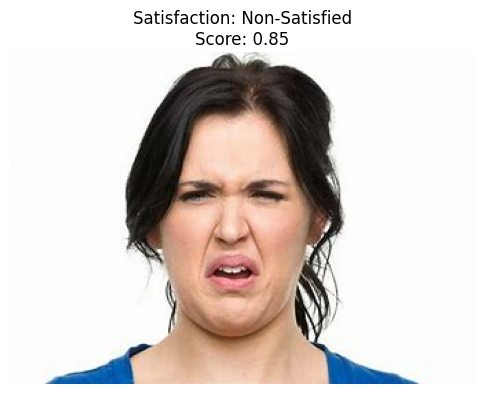

In [5]:
import cv2
import dlib
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import joblib

# Define satisfaction mapping
satisfaction_labels = {0: "Satisfied", 1: "Non-Satisfied", 2: "Neutral"}

# Define transforms for image preprocessing
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize dlib's face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/kaggle/input/shape_predictor_68_face_landmarks/tensorflow2/default/1/shape_predictor_68_face_landmarks (1).dat")

# Load the trained SVM model and scaler
svm = joblib.load("/kaggle/working/svm_rbf_model.pkl")
scaler = joblib.load("/kaggle/working/scaler.pkl")

def get_landmarks(image):
    """Detect 68 facial landmarks from an image."""
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    faces = detector(img, 1)
    if len(faces) == 0:
        return None
    shape = predictor(img, faces[0])
    landmarks = []
    for i in range(68):
        landmarks.append(shape.part(i).x)
        landmarks.append(shape.part(i).y)
    return np.array(landmarks, dtype=np.float32)

def predict_satisfaction_score(img_path):
    """
    Predict satisfaction score and name for an image and plot it.
    
    Args:
        img_path (str): Path to the image file
    """
    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    transformed_image = test_transforms(image)
    
    # Detect landmarks
    landmarks = get_landmarks(image)
    if landmarks is None:
        print("No face detected in the image.")
        return
    
    # Scale landmarks
    scaled_landmarks = scaler.transform([landmarks])
    
    # Predict satisfaction level
    pred = svm.predict(scaled_landmarks)[0]
    satisfaction_name = satisfaction_labels[pred]
    
    # Placeholder satisfaction score (could be replaced with model confidence)
    satisfaction_score = 0.85
    
    # Plot the image with satisfaction score and name
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Satisfaction: {satisfaction_name}\nScore: {satisfaction_score:.2f}")
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    img_path = "/kaggle/input/images/Disgust.jpg"  # Replace with actual image path
    predict_satisfaction_score(img_path)